# TP 03 - Vision por Computadoras I

**Alumno**: Matias Tripode

# Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

### 1) Obtener una detección del logo en cada imagen sin falsos positivos

In [1645]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


In [1646]:
def modificar_resolucion_arbitratia(image, start, top, num):
    scales = np.linspace(start, top, num)
    resized = []
    for scale in scales:
        # Redimensionar la imagen a cada escala
        resized.append(cv.resize(image, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR))
    return resized

-----------------

**Cargar las imagenes**

In [1647]:
# Cargamos la imagen a procesar

#img = cv.imread('images/coca_logo_1.png') # ok
#img = cv.imread('images/coca_logo_2.png') # X, encuentra pero no con el mejor score 
#img = cv.imread('images/coca_retro_1.png') # X, encuentra pero no con el mejor score
img = cv.imread('images/coca_retro_2.png') # ok
#img = cv.imread('images/COCA-COLA-LOGO.jpg') # X, encuentra pero no con el mejor score
#img = cv.imread('images/logo_1.png') # ok

**Pre-procesado**

In [1648]:
# -----------------
# Imagen de entrada
# -----------------
img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
# Escala de grises
img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Resaltar bordes
img_gray = cv.Canny(img_gray, 220, 260, apertureSize = 3)
# Suavizado
img_gray = cv.GaussianBlur(img_gray, (3, 3), 0)
# Normalizar iluminación
img_gray = cv.equalizeHist(img_gray)
# --------
# Template
# --------
template = cv.imread('template/pattern.png')
# Escala de grises
template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
# Suavizado
template_gray = cv.GaussianBlur(template_gray, (3, 3), 0)
# Resaltar bordes
template_edges = cv.Canny(template_gray, 220, 260, apertureSize = 3)

**Graficar template, template pre-procesador, imagen, imagen pre-procesada**

Text(0.5, 1.0, 'Imagen Pre-procesada')

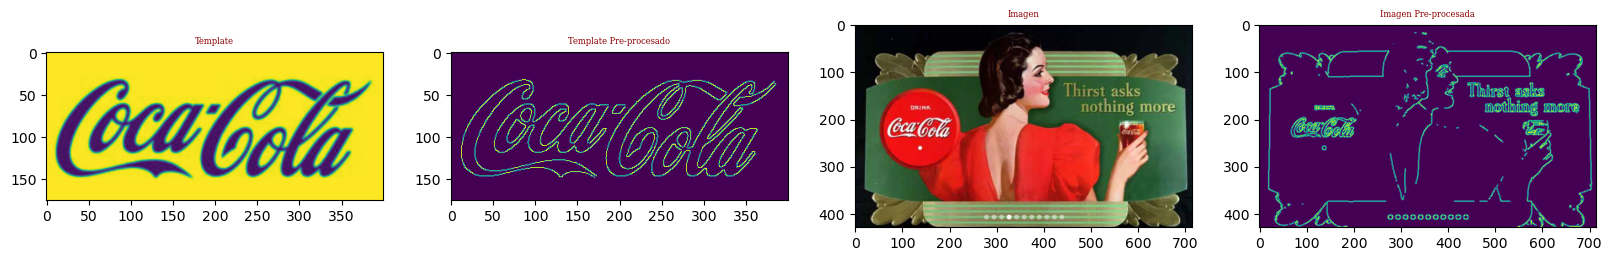

In [1649]:
# --------
# Graficar
# --------
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 6,
        }

plt.figure(figsize=(20, 4))
#
plt.subplot(1,4,1)
plt.imshow(template_gray)
plt.title('Template', font)
#
plt.subplot(1,4,2)
plt.imshow(template_edges)
plt.title('Template Pre-procesado', font)


plt.subplot(1,4,3)
plt.imshow(img_rgb)
plt.title('Imagen', font)
#
plt.subplot(1,4,4), 
plt.imshow(img_gray)
plt.title('Imagen Pre-procesada', font)

In [1650]:
# Calcula el Intersection over Union (IoU) entre dos rectángulos.
def calculate_iou(box1, box2):
    # Determinar coordenadas de la intersección
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    
    # Si no hay intersección
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # Calcular área de intersección
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calcular áreas de cada rectángulo
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # Calcular IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou


In [1651]:
# Ejecuta `matchTemplate` y luego retorna los valores de `minMaxLoc` en un tupla.
# Si el template es mas grande que la imagen, entonces retorna sin ejecutar `matchTemplate`.
def find_match(img_gray, template_gray, method):
    h, w = template_gray.shape
    if template_gray.shape[0] > img_gray.shape[0] or template_gray.shape[1] > img_gray.shape[1]:
        return
    res_map = cv.matchTemplate(img_gray, template_gray, method)
    
    _, max_val, _, max_loc = cv.minMaxLoc(res_map)
    
    return (max_val, (*max_loc, w, h))

In [1652]:
# Encuentra las mejores múltiples coincidencias usando diferentes escales de template y diferentes metodos.
# Returna el mejor resultado en el indice 0 del arreglo resultante.
def find_best_multiple_matches(img_gray, template_gray, iou_threshold, detectar_multiples=False):
    img_gray = img_gray.copy()
    if template_gray.shape[0] > img_gray.shape[0] or template_gray.shape[1] > img_gray.shape[1]:
        templates_escaladas = modificar_resolucion_arbitratia(template_gray, 0.1, 2.5, 150)
    else:
        templates_escaladas = modificar_resolucion_arbitratia(template_edges, 0.5, 3.5, 150)
    if detectar_multiples:
        templates_escaladas = modificar_resolucion_arbitratia(template_edges, 0.25, 0.35, 150)

    methods = ['cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR_NORMED'] # Metodos de correlacion normalizados, buscamos el maximo.

    matches = []
    for meth in methods:
        method = eval(meth)
        for template in templates_escaladas:
            # Encontrar coincidencias
            match = find_match(img_gray, template, method)
            if match is not None:
                matches.append(match)
            
    # Ordenar coincidencias por score (mayor primero)
    matches.sort(reverse=True, key=lambda x: x[0])
    
    # Filtrar solapamientos usando IoU
    final_matches = []
    for score, (x, y, w, h) in matches:
        current_box = (x, y, x + w, y + h)
        
        # Verificar solapamiento con detecciones ya encontradas, si hay solapamiento ignoramos el match
        overlap = False
        for _, (fx, fy, fw, fh) in final_matches:
            existing_box = (fx, fy, fx + fw, fy + fh)
            current_iou = calculate_iou(current_box, existing_box)
            if current_iou > iou_threshold:
                overlap = True
                break
        # Solo nos quedamos con matches que no se solapen
        if not overlap:
            final_matches.append((score, (x, y, w, h)))
    
    return [match for match in final_matches] # retorna un arreglo de tuplas (score, (x, y, w, h))
   
            

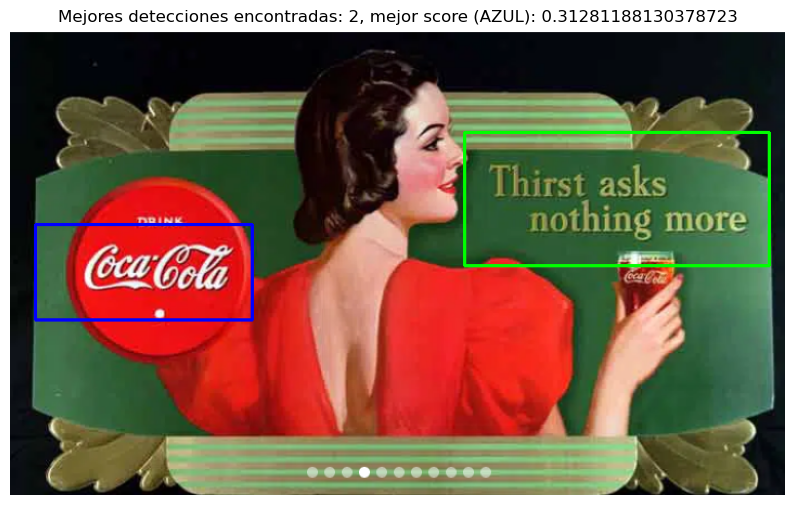

In [1653]:
img_gray_copy = img_gray.copy()
img_rgb_copy = img_rgb.copy()
detections = find_best_multiple_matches(img_gray_copy, template_edges, iou_threshold=0.000000000001)
if detections is None:
    print('No se encontraron matches!!')

# Dibujar rectángulo de la mejores detecciones
for score, (x, y, w, h) in detections:
    cv.rectangle(img_rgb_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

best_score, (x, y, w, h) = detections[0]
cv.rectangle(img_rgb_copy, (x, y), (x+w, y+h), (0, 0, 255), 2)

# Mostrar resultado
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb_copy)
plt.title(f'Mejores detecciones encontradas: {len(detections)}, mejor score (AZUL): {detections[0][0]}')
plt.axis('off')
plt.show()

-----------------------

----------------------------------------

### 2) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1

**Cargar imagenes**

In [1654]:
img = cv.imread('images/coca_multi.png')
template = cv.imread('template/pattern.png')

**Pre-procesado de imagenes**

In [1655]:

# -----------------
# Imagen de entrada
# -----------------
img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
# Escala de grises
img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Resaltar bordes
img_gray = cv.Canny(img_gray, 220, 260, apertureSize = 3)
# Suavizado
img_gray = cv.GaussianBlur(img_gray, (3, 3), 0)
# Normalizar iluminación
img_gray = cv.equalizeHist(img_gray)
# --------
# Template
# --------
# Escala de grises
template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
# Suavizado
template_gray = cv.GaussianBlur(template_gray, (3, 3), 0)
# Resaltar bordes
template_edges = cv.Canny(template_gray, 220, 260, apertureSize = 3)


**Graficar template, template pre-procesador, imagen, imagen pre-procesada**

Text(0.5, 1.0, 'Imagen Pre-procesada')

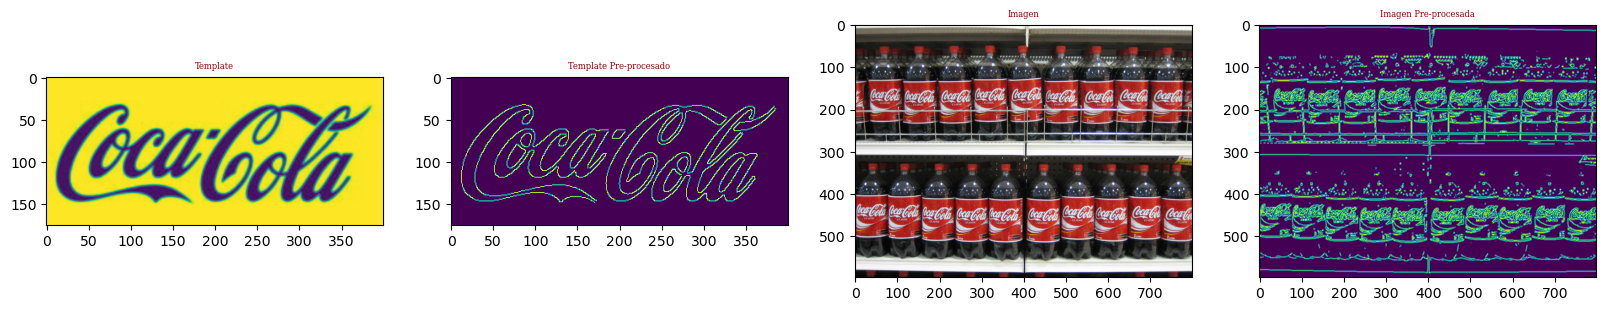

In [1656]:
plt.figure(figsize=(20, 4))
#
plt.subplot(1,4,1)
plt.imshow(template_gray)
plt.title('Template', font)
#
plt.subplot(1,4,2)
plt.imshow(template_edges)
plt.title('Template Pre-procesado', font)


plt.subplot(1,4,3)
plt.imshow(img_rgb)
plt.title('Imagen', font)
#
plt.subplot(1,4,4), 
plt.imshow(img_gray)
plt.title('Imagen Pre-procesada', font)

In [1657]:
def downscale_resolucion_piramides(img, levels):
    base = img.copy()
    piramide_gauss = [base]
    for i in range(levels):
        base = cv.pyrDown(base)
        piramide_gauss.append(base)
    return piramide_gauss

def downscale_resolucion(img, levels):
    base = img.copy()
    for i in range(levels):
        base = cv.pyrDown(base)
    return base

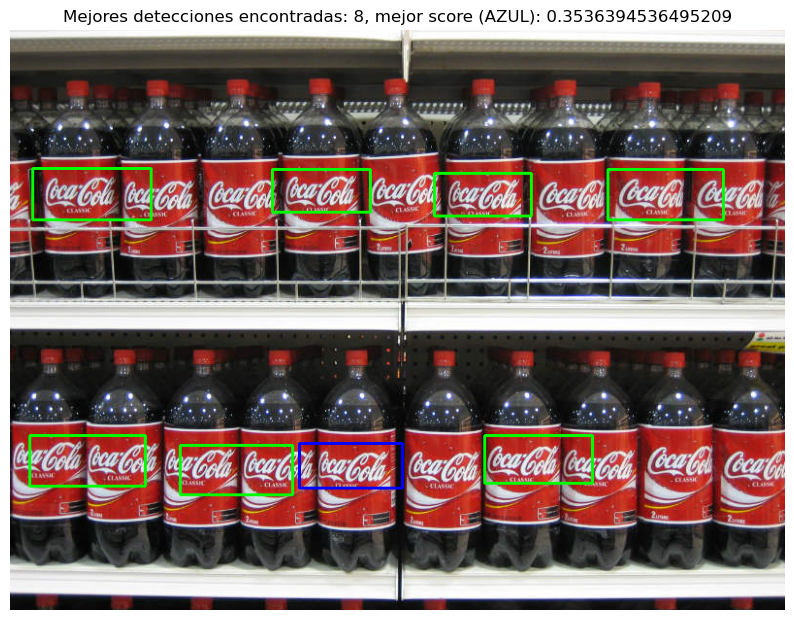

In [1658]:
img_gray_copy = img_gray.copy()
img_rgb_copy = img_rgb.copy()
detections = find_best_multiple_matches(img_gray_copy, template_edges, iou_threshold=0.000000000001, detectar_multiples=True)
if detections is None:
    print('No se encontraron matches!!')

# Dibujar rectángulo de la mejores detecciones
for score, (x, y, w, h) in detections:
    cv.rectangle(img_rgb_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

best_score, (x, y, w, h) = detections[2]
cv.rectangle(img_rgb_copy, (x, y), (x+w, y+h), (0, 0, 255), 2)

# Mostrar resultado
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb_copy)
plt.title(f'Mejores detecciones encontradas: {len(detections)}, mejor score (AZUL): {detections[2][0]}')
plt.axis('off')
plt.show()